# Detecting Suicidal Tendencies from text

## Import Libraries

In [1]:
import numpy as np 
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score

import tensorflow as tf
from tensorflow.keras.layers import Embedding,Dense,LSTM,Bidirectional,GlobalMaxPooling1D,Input,Dropout
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import Sequential, load_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.corpus import stopwords
import string

from tqdm import tqdm
import seaborn as sns
from wordcloud import WordCloud
import pickle
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [2]:
data = pd.read_csv('./data/Suicide_Messages.csv')
data = data.drop("Unnamed: 0", axis=1)

In [3]:
data.head()

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


## EDA

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    232074 non-null  object
 1   class   232074 non-null  object
dtypes: object(2)
memory usage: 3.5+ MB


In [5]:
data.describe()

,text,class
count,232074,232074
unique,232074,2
top,I just want to be happyAll I want is to be lov...,suicide
freq,1,116037


In [6]:
data.isnull().sum()

text     0
class    0
dtype: int64

## Data Cleaning

In [7]:
# Drop Duplicates
data = data.drop_duplicates()

In [8]:
data

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
...,...,...
232069,If you don't like rock then your not going to ...,non-suicide
232070,You how you can tell i have so many friends an...,non-suicide
232071,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide
232072,The usual stuff you find hereI'm not posting t...,suicide


In [9]:
data.iloc[0]["text"]

"Ex Wife Threatening SuicideRecently I left my wife for good because she has cheated on me twice and lied to me so much that I have decided to refuse to go back to her. As of a few days ago, she began threatening suicide. I have tirelessly spent these paat few days talking her out of it and she keeps hesitating because she wants to believe I'll come back. I know a lot of people will threaten this in order to get their way, but what happens if she really does? What do I do and how am I supposed to handle her death on my hands? I still love my wife but I cannot deal with getting cheated on again and constantly feeling insecure. I'm worried today may be the day she does it and I hope so much it doesn't happen."

In [10]:
def geenerate_word_cloud():
    pass

In [11]:
data["text"].values

array(["Ex Wife Threatening SuicideRecently I left my wife for good because she has cheated on me twice and lied to me so much that I have decided to refuse to go back to her. As of a few days ago, she began threatening suicide. I have tirelessly spent these paat few days talking her out of it and she keeps hesitating because she wants to believe I'll come back. I know a lot of people will threaten this in order to get their way, but what happens if she really does? What do I do and how am I supposed to handle her death on my hands? I still love my wife but I cannot deal with getting cheated on again and constantly feeling insecure. I'm worried today may be the day she does it and I hope so much it doesn't happen.",
       "Am I weird I don't get affected by compliments if it's coming from someone I know irl but I feel really good when internet strangers do it",
       'Finally 2020 is almost over... So I can never hear "2020 has been a bad year" ever again. I swear to fucking God it\'

## Data Preprocessing Pipeline

In [73]:
# lowercase
def lower_case(sent):
    return sent.lower()

In [74]:
# Removing Punctuation
def remove_punctuation(sent):
    return "".join([char for char in sent if char not in string.punctuation])

In [75]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [76]:
# Tokenize
def tokenize_sent(sent):
    return nltk.word_tokenize(sent)

In [77]:
# Stopword Filtering
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [78]:
def filter_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

In [79]:
# Lemmatization
wordnet_lemmatizer = nltk.WordNetLemmatizer()

In [80]:
def lemmatizer(tokens):
    return [wordnet_lemmatizer.lemmatize(word) for word in tokens]

In [81]:
def preprocess_pipeline(sentence):
    sent = lower_case(sentence)
    sent = remove_punctuation(sent)
    
    sent_tokens = tokenize_sent(sent)
    sent_tokens = filter_stopwords(sent_tokens)
    
    preprocessed_tokens = lemmatizer(sent_tokens)
    
    return preprocessed_tokens

### Preprocess the Data

In [22]:
data["preprocessed text"] = data["text"].apply(preprocess_pipeline)

In [23]:
data.head()

,text,class,preprocessed text
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,"[ex, wife, threatening, suiciderecently, left,..."
1,Am I weird I don't get affected by compliments...,non-suicide,"[weird, dont, get, affected, compliment, comin..."
2,Finally 2020 is almost over... So I can never ...,non-suicide,"[finally, 2020, almost, never, hear, 2020, bad..."
3,i need helpjust help me im crying so hard,suicide,"[need, helpjust, help, im, cry, hard]"
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,"[’, losthello, name, adam, 16, ’, struggling, ..."


In [25]:
data.to_csv("./data/preprocessed_suicide_messages.csv", index=False)

In [26]:
data = pd.read_csv("./data/preprocessed_suicide_messages.csv")

In [27]:
data

,text,class,preprocessed text
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,"['ex', 'wife', 'threatening', 'suiciderecently..."
1,Am I weird I don't get affected by compliments...,non-suicide,"['weird', 'dont', 'get', 'affected', 'complime..."
2,Finally 2020 is almost over... So I can never ...,non-suicide,"['finally', '2020', 'almost', 'never', 'hear',..."
3,i need helpjust help me im crying so hard,suicide,"['need', 'helpjust', 'help', 'im', 'cry', 'hard']"
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,"['’', 'losthello', 'name', 'adam', '16', '’', ..."
...,...,...,...
232069,If you don't like rock then your not going to ...,non-suicide,"['dont', 'like', 'rock', 'going', 'get', 'anyt..."
232070,You how you can tell i have so many friends an...,non-suicide,"['tell', 'many', 'friend', 'lonely', 'everythi..."
232071,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide,"['pee', 'probably', 'taste', 'like', 'salty', ..."
232072,The usual stuff you find hereI'm not posting t...,suicide,"['usual', 'stuff', 'find', 'hereim', 'posting'..."


## Train Test Split

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(data["preprocessed text"], data["class"], test_size=0.3)

In [30]:
len(X_train), len(X_test), len(y_train), len(y_test)

(162451, 69623, 162451, 69623)

## Encode Data

In [31]:
le = LabelEncoder()
y_train = le.fit_transform(y_train.values)
y_test = le.transform(y_test.values)

In [32]:
encoder = list(le.classes_)
encoder

['non-suicide', 'suicide']

## Tokenize and Pad Data

In [31]:
data["text"].map(len).argmax()

186905

In [33]:
# sentence with maximum length
len(data.iloc[186905].text.split())

7378

In [37]:
# Tokenize
embed_size = 150 # how big is each word vector
max_feature = 5000 # how many unique words to use
max_len = 2000 # max number of words to use

In [38]:
from keras.preprocessing.text import Tokenizer

In [39]:
tokenizer = Tokenizer(num_words = max_feature)
tokenizer.fit_on_texts(X_train)

In [40]:
with open("./API/suicide_tokenizer.obj", "wb") as f:
    pickle.dump(tokenizer, f)

In [41]:
X_train = np.array(tokenizer.texts_to_sequences(X_train))
X_test = np.array(tokenizer.texts_to_sequences(X_test))

In [42]:
# Padding
from keras.preprocessing.sequence import pad_sequences

In [43]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

## Building the AI Model I - Bi - LSTM

In [44]:
embedding_vector_length = 64

def get_model(embedding_vector_length):

    model = tf.keras.Sequential()
    model.add(Embedding(max_feature, embedding_vector_length, input_length = max_len))
    model.add(Bidirectional(tf.keras.layers.LSTM(128)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [45]:
model = get_model(embedding_vector_length)

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              197632    
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                        

## Training the AI model

In [47]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2),
            tf.keras.callbacks.ModelCheckpoint(
              filepath='suicide_pred_model.h5',
              save_weights_only=False,
              monitor='val_loss',
              save_best_only=True),
            ]

In [48]:
history = model.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_test, y_test),callbacks = [callback])

Epoch 1/20
2539/2539 [==============================] - 730s 286ms/step - loss: 0.2367 - accuracy: 0.9161 - val_loss: 0.1828 - val_accuracy: 0.9328
Epoch 2/20
2539/2539 [==============================] - 857s 338ms/step - loss: 0.1856 - accuracy: 0.9344 - val_loss: 0.1773 - val_accuracy: 0.9344
Epoch 3/20
2539/2539 [==============================] - 866s 341ms/step - loss: 0.1670 - accuracy: 0.9397 - val_loss: 0.1787 - val_accuracy: 0.9343
Epoch 4/20
2539/2539 [==============================] - 678s 267ms/step - loss: 0.1529 - accuracy: 0.9444 - val_loss: 0.1745 - val_accuracy: 0.9355
Epoch 5/20
2539/2539 [==============================] - 833s 328ms/step - loss: 0.1384 - accuracy: 0.9492 - val_loss: 0.1846 - val_accuracy: 0.9344
Epoch 6/20
2539/2539 [==============================] - 1018s 401ms/step - loss: 0.1248 - accuracy: 0.9543 - val_loss: 0.1849 - val_accuracy: 0.9301


In [49]:
model.evaluate(X_test, y_test)

2176/2176 [==============================] - 264s 122ms/step - loss: 0.1849 - accuracy: 0.9301


[0.18488366901874542, 0.9300805926322937]

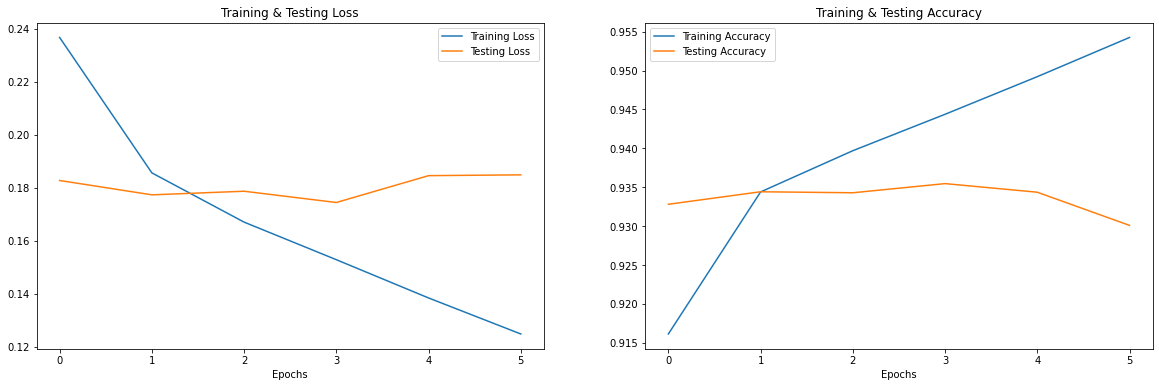

In [51]:
epochs = [i for i in range(6)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [52]:
# model = load_model("./suicide_pred_model.h5")
model = load_model("./suicide_pred_model.h5")

In [53]:
model.evaluate(X_test, y_test)

2176/2176 [==============================] - 202s 92ms/step - loss: 0.1745 - accuracy: 0.9355s - loss: 0.1 - ETA: 0s - loss: 0.1744 - accuracy: 


[0.17445382475852966, 0.9354523420333862]

In [54]:
pred = model.predict(X_test)

In [55]:
preds = [1 if x> 0.5 else 0 for x in pred]

In [56]:
precision_score(preds, y_test, average="macro")

0.9354522821069048

In [57]:
recall_score(preds, y_test, average="macro")

0.9354531200692158

In [58]:
f1_score(preds, y_test, average="macro")

0.935452327474663

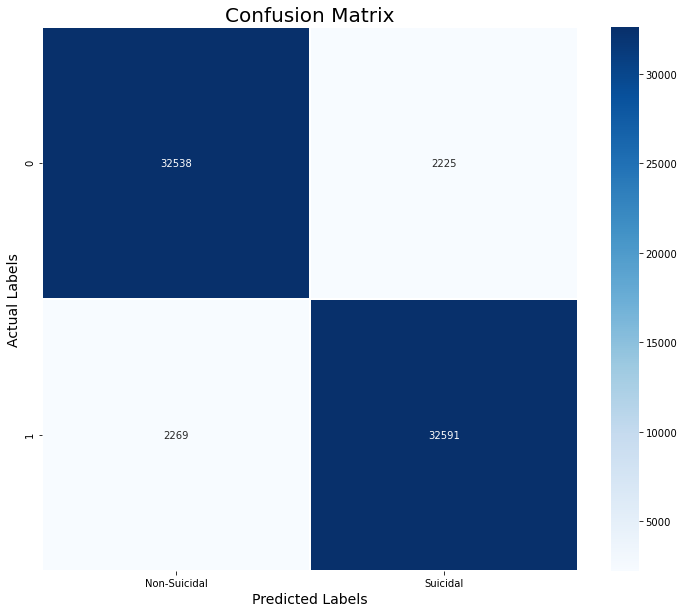

In [59]:
cm = confusion_matrix(preds, y_test)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , columns = ["Non-Suicidal","Suicidal"])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [60]:
print(classification_report(preds, y_test, target_names=["Non-Suicidal","Suicidal"]))

              precision    recall  f1-score   support

Non-Suicidal       0.93      0.94      0.94     34763
    Suicidal       0.94      0.93      0.94     34860

    accuracy                           0.94     69623
   macro avg       0.94      0.94      0.94     69623
weighted avg       0.94      0.94      0.94     69623



## Inference

In [61]:
# Tweets cleaning

def remove_hashtags_mentions(sent):
    removed_mentions = re.sub("@[A-Za-z0-9_]+", "", sent)
    removed_hashtags = re.sub("#[A-Za-z0-9_]+","", removed_mentions)
    return removed_hashtags

In [62]:
# lowercase
def lower_case(sent):
    return sent.lower()

In [63]:
# Removing Punctuation
def remove_punctuation(sent):
    return " ".join([char for char in sent.split() if char not in string.punctuation])

In [64]:
# Tokenize
def tokenize_sent(sent):
    return nltk.word_tokenize(sent)

In [65]:
def filter_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

In [66]:
# Lemmatization
wordnet_lemmatizer = nltk.WordNetLemmatizer()

In [67]:
def lemmatizer(tokens):
    return [wordnet_lemmatizer.lemmatize(word) for word in tokens]

In [68]:
def clean_pipeline(sentence):
    sent = remove_hashtags_mentions(sentence)
    sent = lower_case(sent)
    sent = remove_punctuation(sent)
    
    sent_tokens = tokenize_sent(sent)
    sent_tokens = filter_stopwords(sent_tokens)
    
    preprocessed_tokens = lemmatizer(sent_tokens)
    
    return preprocessed_tokens

In [69]:
embed_size = 150 # how big is each word vector
max_feature = 5000 # how many unique words to use
max_len = 2000 # max number of words to use

In [56]:
model = load_model("./API/suicide_pred_model.h5")

In [70]:
import re

In [71]:
def suicide_pipeline(text):
    if type(text) is str:
        p_text = clean_pipeline(text)
        sequences = tokenizer.texts_to_sequences([p_text])
    else:
        p_text = [clean_pipeline(x) for x in text]
        sequences = tokenizer.texts_to_sequences(p_text)
        
    padded = pad_sequences(sequences, maxlen=max_len)
    padded = np.array(padded)
    
    pred = model.predict(padded)
    emotion = ["Suicidal" if x > 0.5 else "Not Suicidal"  for x in pred]
    percentage = [x[0] * 100 for x in pred]

    return list(zip(emotion, percentage))

In [82]:
suicide_pipeline(["lol", "Dieee"])

[('Not Suicidal', 23.295828700065613), ('Not Suicidal', 23.295828700065613)]

In [ ]:
import json

In [ ]:
json.dumps(depression_pipeline(["I wanna jump off a cliff", "Dieee"]))